# Matej Horniak, Lukáš Mikula
### 2. fáza projektu
Dátová sada č. 44

In [117]:
import scipy.stats as stats
import pandas as pd
import numpy as np
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute._iterative import IterativeImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil.parser as parser
from sklearn.impute import SimpleImputer as Imputer, SimpleImputer
from sklearn.neighbors import NearestNeighbors as neigh
from sklearn.neighbors import KNeighborsRegressor as neigh
from sklearn.model_selection import train_test_split as split
from sklearn import metrics
from math import sqrt
import json
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from missingpy import KNNImputer, MissForest
import copy



Zmenili sme mierne pristup riesenia parsovania jsonu a chybajucivh hodnot v nom, nakolko prvotne nahradzanie za nulove hodnoty nebolo validne. Teraz sme najprv nahradili hodnoty za velmi velke cisla, ktore sa v datach nenachadzaju a nasledne sme tieto cisla vymenili za NaN.

In [118]:
data = pd.read_csv("../data/other_train.csv",index_col=0)

dict_array = []
string = '{"mean_glucose": 9999999,"std_glucose": 9999999,"kurtosis_glucose":9999999,"skewness_glucose":9999999,"mean_oxygen":9999999,"std_oxygen":9999999,"kurtosis_oxygen":9999999,"skewness_oxygen":9999999}'
data.medical_info.apply(lambda x: dict_array.append(json.loads(x.replace("'","\"").replace(":\"",":").replace("\",",",").replace("\"}","}") if isinstance(x,str) else string)))
medical_datas = pd.DataFrame(dict_array)

for item in medical_datas:
    data[item] = medical_datas[item].astype(float)
data = data.drop(columns=['medical_info'])
# print(data)
# data.info()

person = pd.read_csv("../data/personal_train.csv",index_col=0)
# print(person)
# person.info()

Pokial boli v datach volne bunky alebo sa tam nachadzali otazniky s medzerami, vymenili sme tieto hodnoty za NaN.

In [119]:

data = data.replace({ 9999999 : np.nan },regex=False)
data = data.replace({'^[? ]*$' : np.nan},regex=True)
person = person.replace({'^[? ]*$' : np.nan},regex=True)
og = copy.deepcopy(data) 

Rozdelili sme si data na 2 casti, teda na spojite a diskretne. 

Taktiez sme nahradili vsetky duplikaty, pricom pri spojitych sme pouzili agregacnu funkciu mean a pri diskretnych zasa agregacnu funkciu first.

Nasledne sme tieto data spojili naspat dokopy.

In [120]:
numeric = data.select_dtypes(include=['float64'])
categoric = data.select_dtypes(include=['object'])
numeric['name'] = categoric['name']

numeric = numeric.groupby('name').aggregate('mean')
categoric = categoric.groupby('name').aggregate('first')

data = categoric.merge(numeric, on=['name'])

C:\Users\Lukas\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Potom sme na zaklade mena a adresy spojili dva subory, teda personal a other.

In [121]:
merged_data = pd.merge(person, data, on=['name','address'], how='left')

Tu riesime nejednotne data a hodnoty a vymiename ich za jednotne tvary.

A dalej parsujeme datumy. A pocitame vek na zaklade datumu narodenia.

In [122]:
merged_data = merged_data.replace(['FALSE','F'],'f',regex=True)
merged_data = merged_data.replace(['TRUE','T'],'t',regex=True)

merged_data = merged_data.replace([' <=50K'],'<=50K',regex=True)
merged_data = merged_data.replace([' >50K'],'>50K',regex=True)


merged_data = merged_data.replace([' Other-relative'],'Other_relative',regex=True)
merged_data = merged_data.replace([' Not-in-family'],'Not_in_family',regex=True)
merged_data = merged_data.replace([' Own-child'],'Own_child',regex=True)


for i, row in merged_data.iterrows():
        
    date = parser.parse(merged_data.iloc[i]['date_of_birth'].split(' ')[0])
    day = date.day
    month = date.month
    year = date.year
    
    if (year > 2019):
        year = year - 100

    merged_data.at[i,'date_of_birth'] = str(day) + "/" + str(month) + "/" + str(year)
            
    if ((pd.isna(row['age'])) | (row['age'] > 115) | (row['age'] < 0)):
        merged_data.at[i,'age'] = 2019 - year

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 28 columns):
name                3933 non-null object
address             3933 non-null object
age                 3933 non-null float64
sex                 3933 non-null object
date_of_birth       3933 non-null object
race                3933 non-null object
marital-status      3933 non-null object
occupation          3703 non-null object
pregnant            3931 non-null object
relationship        3932 non-null object
education           3933 non-null object
income              3932 non-null object
native-country      3872 non-null object
workclass           3341 non-null object
education-num       3933 non-null float64
capital-gain        3933 non-null float64
fnlwgt              3932 non-null float64
class               3933 non-null float64
hours-per-week      3932 non-null float64
capital-loss        3933 non-null float64
mean_glucose        3932 non-null float64
std_glucose         3932

In [123]:
# Remove outliers which can be probably not use
# print(merged_data['education-num'].value_counts())
# sns.distplot(merged_data['education-num'])

# ## Remove outliers from education-num
# # sns.boxplot(merged_data['education-num'])
# merged_data.loc[merged_data['education-num'] < 5,'education-num'] = np.NaN
# # sns.boxplot(merged_data['education-num'])
# 
# ## Remove outliers from 'capital-gain'
# # sns.boxplot(merged_data['capital-gain'])
# merged_data.loc[merged_data['capital-gain'] > 30000,'capital-gain'] = np.NaN
# # sns.boxplot(merged_data['capital-gain'])
# 
# ## Remove outliers from 'fnlwgt'
# # sns.boxplot(merged_data['fnlwgt'])
# merged_data.loc[merged_data['fnlwgt'] > 800000,'fnlwgt'] = np.NaN
# # sns.boxplot(merged_data['fnlwgt'])
# 
# ## Remove outliers from 'hours-per-week'
# # sns.boxplot(merged_data['hours-per-week'])
# merged_data.loc[(merged_data['hours-per-week'] > 57) | (merged_data['hours-per-week'] < 8),'hours-per-week'] = np.NaN
# # sns.boxplot(merged_data['hours-per-week'])

Nasleduje odstranovanie outlierov z dat z povodneho stlpca medical info, pricom na povodne miesto nahradime NaN, ktory sa bude dalej nahradzovat v dalsej bunke.

In [124]:
# Remove outliers on floats datas

## Remove outliers from 'kurtosis_glucose'
column = 'kurtosis_glucose'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 6) | (merged_data[column] < -1)
merged_data.loc[mask ,column] = np.NaN

## Remove outliers from 'mean_glucose'
column = 'mean_glucose'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 150)  
merged_data.loc[mask ,column] = np.NaN

## Remove outliers from 'mean_oxygen'
column = 'mean_oxygen'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 120)  
merged_data.loc[mask ,column] = np.NaN

## Remove outliers from 'kurtosis_oxygen'
column = 'kurtosis_oxygen'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 20)  
merged_data.loc[mask ,column] = np.NaN

## Remove outliers from 'skewness_glucose'
column = 'skewness_glucose'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 40)  
merged_data.loc[mask ,column] = np.NaN

## Remove outliers from 'skewness_oxygen'
column = 'skewness_oxygen'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 350)  
merged_data.loc[mask ,column] = np.NaN

## Remove outliers from 'std_glucose'
column = 'std_glucose'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 62) 
merged_data.loc[mask ,column] = np.NaN

## Remove outliers from 'std_oxygen'
column = 'std_oxygen'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 80)  
merged_data.loc[mask ,column] = np.NaN


Rozdelujeme si dataset na 3 kategorie, na prvych 5 numerickych, zvysne numericke a nasledne kategoricke.

Aby sme vedeli pri nahradzani chybajucich dat vyuzit viacere techniky nahradzania.

In [125]:
# Divide datas into 3 category

old = merged_data
merged_data = merged_data.drop(columns=['class'])
age_column = copy.deepcopy(merged_data['age'])
merged_data = merged_data.drop(columns=['age'])
merged_data['age'] = age_column

numeric = merged_data.select_dtypes(include=['float64'])
numeric1 = numeric.iloc[:,:5].columns
print(numeric1)
numeric2 = numeric.iloc[:,5:].columns
print(numeric2)  
categoric = merged_data.select_dtypes(include=['object']).columns
print(categoric)

Index(['education-num', 'capital-gain', 'fnlwgt', 'hours-per-week',
       'capital-loss'],
      dtype='object')
Index(['mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose',
       'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen',
       'age'],
      dtype='object')
Index(['name', 'address', 'sex', 'date_of_birth', 'race', 'marital-status',
       'occupation', 'pregnant', 'relationship', 'education', 'income',
       'native-country', 'workclass'],
      dtype='object')


Zadefinujeme si jednotlive kroky pipelines, pricom na prvu skupinu numerickych hodnot pouzivame MissForest a PowerTransformer (pre upravenie dat, aby boli z gausovho rozdelenia) a na druhu skupinu pouzivame KNN. A na kategoricke data pouzivame najcastejsiu hodnotu.

In [126]:
# Apply pipeline in category 

numeric_transformer1 = Pipeline(steps=[('imputer',MissForest(missing_values=np.NaN, max_iter=10, # Nahradenie nulovych hodnot pomocou MissForest
                                                             decreasing=False, copy=False)), 
                                      ('powerTransformer',PowerTransformer(method='yeo-johnson',
                                                                           copy=False)) # Transformuje dat aby boli viac z Gaussoveho rozdelenia
                                       ])
numeric_transformer2 = Pipeline(steps=[('imputer',KNNImputer(missing_values=np.NaN, n_neighbors=5, # Nahradenie nulovych hodnot pomocou KNN
                                                              weights='distance')), 
                                     # ('RobustScaler',StandardScaler())    # 
                                       ])
categoric_transormer = Pipeline(steps=[('imputer',SimpleImputer(strategy='most_frequent'))]) # Nahradenie nulovych hodnot pomocou najcastejsich hodnot
                                      # ('onehot',OneHotEncoder(handle_unknown='ignore'))])
preproccesors = ColumnTransformer(transformers=[('Cat', categoric_transormer, categoric),
                                                ('Num1', numeric_transformer1, numeric1),
                                                ('Num2', numeric_transformer2, numeric2)
                                                ])


Vykoname jednotlive kroky pipelines, pricom ich ucime a hned aj transformujeme.

In [127]:
# Execute pipeline steps

pipeline = Pipeline(steps=[('preproccesors', preproccesors)])
pipeline_datas = pipeline.fit_transform(merged_data)

Iteration: 0
Iteration: 1
Iteration: 2


C:\Users\Lukas\Anaconda3\lib\site-packages\missingpy\knnimpute.py:224: UserWarning: There are rows with more than 50.0% missing values. These rows are not included as donor neighbors.
  .format(self.row_max_missing * 100))
C:\Users\Lukas\Anaconda3\lib\site-packages\missingpy\knnimpute.py:282: UserWarning: There are rows with more than 50.0% missing values. The missing features in these rows are imputed with column means.
  .format(self.row_max_missing * 100))
C:\Users\Lukas\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Lukas\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Lukas\Anaconda3\lib\site-packages\missing

Pozrieme sa do jednotlivych dat, aby sme zistili, ci su fajnovucke.

In [128]:
# Show mereged datas

merged_data = pd.DataFrame(pipeline_datas,columns=merged_data.columns)
print(merged_data)


                     name                                            address  \
0         Roscoe Bohannon  7183 Osborne Ways Apt. 651\r\nEast Andrew, OH ...   
1            Ernest Kline  391 Ball Road Suite 961\r\nflowersborough, IN ...   
2         Harold Hendriks     8702 Vincent Square\r\nNew Jerryfurt, CO 30614   
3          Randy Baptiste     2751 Harris Crossroad\r\nWest Ashley, CA 30311   
4         Anthony Colucci  904 Robert Cliffs Suite 186\r\nWest Kyle, CO 7...   
...                   ...                                                ...   
3928      Clair Pinkleton             8582 Lee Roads\r\nCostaburgh, SC 21897   
3929         William Pope  68430 Erik terrace Suite 279\r\nPort Adamborou...   
3930         Jared Kinsey                 Unit 8416 Box 3801\r\nDPO AE 31166   
3931     frederick Lawley   34420 Brian Stream\r\nLake Michaeltown, MS 01832   
3932  Adalberto Daughters                 Unit 7931 Box 0601\r\nDPO AE 50505   

          sex date_of_birth            

Tu prebieha pretypovanie niektorych dat, nakolko nam z nich pipelines urobili objekty a povodne boli tieto data floaty.

Taktiez vraciame naspat stlpec class, ktory bol predtym odobraty z dat.

In [129]:
merged_data['age'] = merged_data['age'].astype(np.float64)
merged_data['education-num'] = merged_data['education-num'].astype(np.float64)
merged_data['capital-gain'] = merged_data['capital-gain'].astype(np.float64)
merged_data['fnlwgt'] = merged_data['fnlwgt'].astype(np.float64)
# merged_data['class'] = merged_data['class'].astype(np.float64)
merged_data['hours-per-week'] = merged_data['hours-per-week'].astype(np.float64)
merged_data['capital-loss'] = merged_data['capital-loss'].astype(np.float64)
merged_data['mean_glucose'] = merged_data['mean_glucose'].astype(np.float64)
merged_data['std_glucose'] = merged_data['std_glucose'].astype(np.float64)
merged_data['kurtosis_glucose'] = merged_data['kurtosis_glucose'].astype(np.float64)
merged_data['skewness_glucose'] = merged_data['skewness_glucose'].astype(np.float64)
merged_data['mean_oxygen'] = merged_data['mean_oxygen'].astype(np.float64)
merged_data['std_oxygen'] = merged_data['std_oxygen'].astype(np.float64)
merged_data['kurtosis_oxygen'] = merged_data['kurtosis_oxygen'].astype(np.float64)
merged_data['skewness_oxygen'] = merged_data['skewness_oxygen'].astype(np.float64)
merged_data['class'] = old['class'].astype(np.int64)
print(merged_data)

                     name                                            address  \
0         Roscoe Bohannon  7183 Osborne Ways Apt. 651\r\nEast Andrew, OH ...   
1            Ernest Kline  391 Ball Road Suite 961\r\nflowersborough, IN ...   
2         Harold Hendriks     8702 Vincent Square\r\nNew Jerryfurt, CO 30614   
3          Randy Baptiste     2751 Harris Crossroad\r\nWest Ashley, CA 30311   
4         Anthony Colucci  904 Robert Cliffs Suite 186\r\nWest Kyle, CO 7...   
...                   ...                                                ...   
3928      Clair Pinkleton             8582 Lee Roads\r\nCostaburgh, SC 21897   
3929         William Pope  68430 Erik terrace Suite 279\r\nPort Adamborou...   
3930         Jared Kinsey                 Unit 8416 Box 3801\r\nDPO AE 31166   
3931     frederick Lawley   34420 Brian Stream\r\nLake Michaeltown, MS 01832   
3932  Adalberto Daughters                 Unit 7931 Box 0601\r\nDPO AE 50505   

          sex date_of_birth            

Tu porovnavame typy stlpcov medzi povodnymi datami a nami upravenymi datami.

og obsahuje povodne data.

merged_data obsahuje nami zmenene data.

Mozme tu taktiez vidiet, ze sa v datach uz nevyskytuju ziadne nulove hodnoty a pocet zaznamov sa mierne znizil o duplikaty.

In [130]:
og.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3983 entries, 0 to 3982
Data columns (total 25 columns):
name                3983 non-null object
address             3983 non-null object
race                3970 non-null object
marital-status      3965 non-null object
occupation          3731 non-null object
pregnant            3961 non-null object
education-num       3962 non-null float64
relationship        3967 non-null object
capital-gain        3970 non-null float64
education           3967 non-null object
fnlwgt              3966 non-null float64
class               3966 non-null float64
income              3965 non-null object
native-country      3905 non-null object
hours-per-week      3968 non-null float64
capital-loss        3969 non-null float64
workclass           3366 non-null object
mean_glucose        3964 non-null float64
std_glucose         3964 non-null float64
kurtosis_glucose    3964 non-null float64
skewness_glucose    3964 non-null float64
mean_oxygen         39

In [131]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 28 columns):
name                3933 non-null object
address             3933 non-null object
sex                 3933 non-null object
date_of_birth       3933 non-null object
race                3933 non-null object
marital-status      3933 non-null object
occupation          3933 non-null object
pregnant            3933 non-null object
relationship        3933 non-null object
education           3933 non-null object
income              3933 non-null object
native-country      3933 non-null object
workclass           3933 non-null object
education-num       3933 non-null float64
capital-gain        3933 non-null float64
fnlwgt              3933 non-null float64
hours-per-week      3933 non-null float64
capital-loss        3933 non-null float64
mean_glucose        3933 non-null float64
std_glucose         3933 non-null float64
kurtosis_glucose    3933 non-null float64
skewness_glucose    3933

In [132]:
og.describe(include="all")

,name,address,race,marital-status,occupation,pregnant,education-num,relationship,capital-gain,education,...,capital-loss,workclass,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
count,3983,3983,3970,3965,3731,3961,3962.00000,3967,3970.000000,3967,...,3969.000000,3366,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000
unique,3933,3933,5,6,14,6,NaN,9,NaN,16,...,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,James Menzies,"455 Amber Freeway\r\nWest Timothyland, RI 32037",White,Married-civ-spouse,Craft-repair,f,NaN,Husband,NaN,HS-grad,...,NaN,Private,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3,3,3398,1830,547,3494,NaN,1615,NaN,1306,...,NaN,2518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,10.05477,NaN,1240.338539,NaN,...,91.746536,NaN,101.296270,45.167552,0.951369,4.222697,18.476218,31.163018,7.413264,91.325501
std,NaN,NaN,NaN,NaN,NaN,NaN,2.58377,NaN,8300.936903,NaN,...,412.307694,NaN,33.596246,7.608018,1.611950,9.675803,34.776830,22.291900,4.813020,108.557875
min,NaN,NaN,NaN,NaN,NaN,NaN,1.00000,NaN,0.000000,NaN,...,0.000000,NaN,6.187500,25.695250,-1.641515,-1.755332,0.213211,7.370432,-2.597872,-1.976976
25%,NaN,NaN,NaN,NaN,NaN,NaN,9.00000,NaN,0.000000,NaN,...,0.000000,NaN,87.720703,40.153323,0.071484,-0.120081,2.064799,15.034235,3.629228,12.749103
50%,NaN,NaN,NaN,NaN,NaN,NaN,10.00000,NaN,0.000000,NaN,...,0.000000,NaN,110.671875,45.868605,0.310578,0.375623,3.227007,20.535393,7.787156,68.623477
75%,NaN,NaN,NaN,NaN,NaN,NaN,12.00000,NaN,0.000000,NaN,...,0.000000,NaN,124.160156,50.346566,0.775953,2.083826,12.672659,43.297645,10.269058,127.057043


In [133]:
merged_data.describe(include="all")

,name,address,sex,date_of_birth,race,marital-status,occupation,pregnant,relationship,education,...,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen,age,class
count,3933,3933,3933,3933,3933,3933,3933,3933,3933,3933,...,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000
unique,3933,3933,2,3458,5,6,14,2,9,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Guy Myers,"5642 Morgan Street\r\nEast Allison, KY 69780",Male,7/5/1967,White,Married-civ-spouse,Craft-repair,f,Husband,HS-grad,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,2664,4,3369,1814,770,3850,1597,1292,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.693955,44.993221,0.935117,3.996733,15.951854,30.302621,7.263346,83.578324,51.856089,0.255276
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.921435,7.227453,1.541877,8.778216,27.078138,20.475328,4.439692,79.608417,11.811987,0.436072
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.187500,25.695250,-0.944764,-1.755332,0.213211,7.370432,-2.597872,-1.976976,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,87.742188,40.165726,0.073829,-0.119347,2.065217,15.035776,3.637833,12.866679,44.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,110.562500,45.834440,0.311723,0.375487,3.236622,20.560715,7.779635,68.490474,52.000000,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,123.625000,50.264680,0.778607,2.090761,12.647993,43.094329,10.237197,126.578762,60.000000,1.000000


Dalej porovnavame jednotlive hodnoty z povodneho stplca medical info. Mozeme sporovat rozdiely v rozdeleni tychto dat, taktiez odstranenie outlierov.

Pricom kazdy neparny graf zobrazuje povodne hodnoty a kazdy parny graf zobrazuje upravene hodnoty.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018137ED4278>]],
      dtype=object)

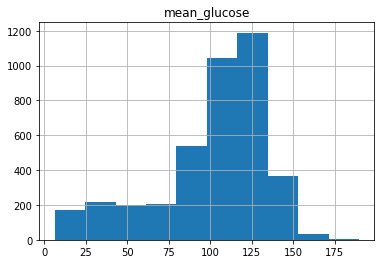

In [134]:
og.hist('mean_glucose')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018137EE6FD0>]],
      dtype=object)

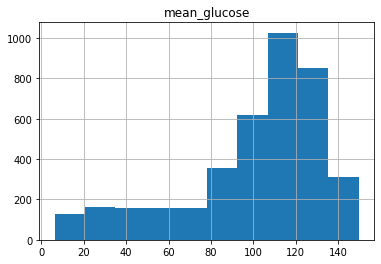

In [135]:
merged_data.hist('mean_glucose')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018137EB5C50>]],
      dtype=object)

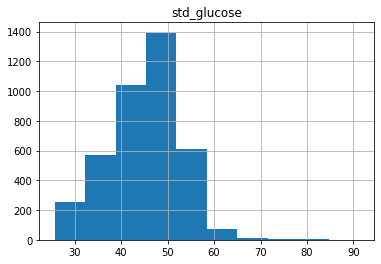

In [136]:
og.hist('std_glucose')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000181196D7C18>]],
      dtype=object)

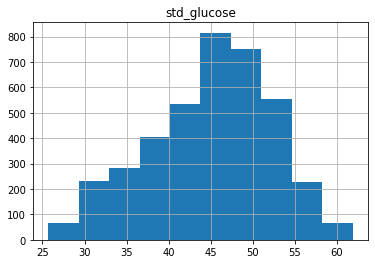

In [137]:
merged_data.hist('std_glucose')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018137FA11D0>]],
      dtype=object)

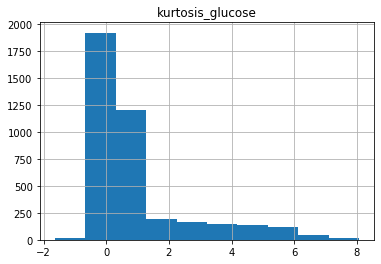

In [138]:
og.hist('kurtosis_glucose')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000181380208D0>]],
      dtype=object)

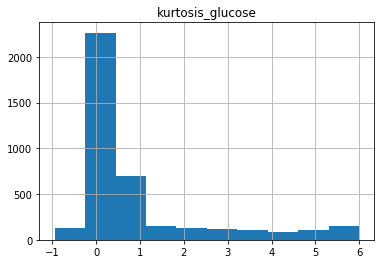

In [139]:
merged_data.hist('kurtosis_glucose')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018137FA1470>]],
      dtype=object)

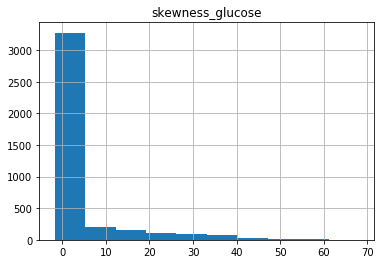

In [140]:
og.hist('skewness_glucose')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001813811DCF8>]],
      dtype=object)

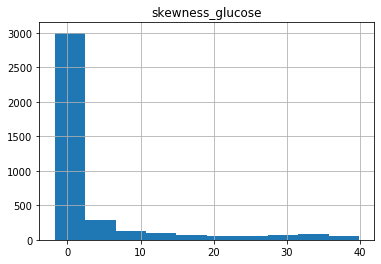

In [141]:
merged_data.hist('skewness_glucose')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018138194EB8>]],
      dtype=object)

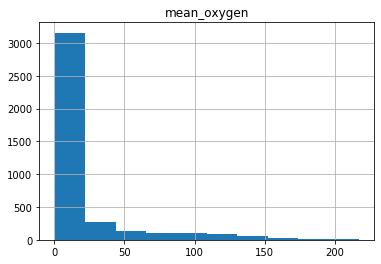

In [142]:
og.hist('mean_oxygen')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018138150A58>]],
      dtype=object)

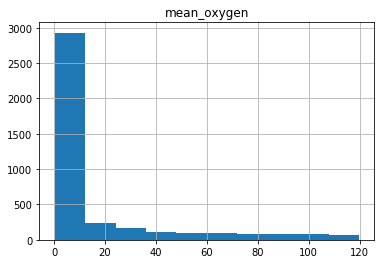

In [143]:
merged_data.hist('mean_oxygen')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018117AF7DD8>]],
      dtype=object)

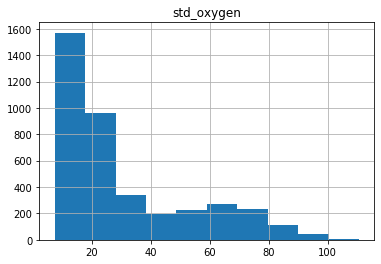

In [144]:
og.hist('std_oxygen')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018138309E48>]],
      dtype=object)

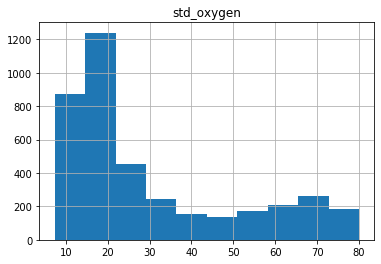

In [145]:
merged_data.hist('std_oxygen')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001813837CE10>]],
      dtype=object)

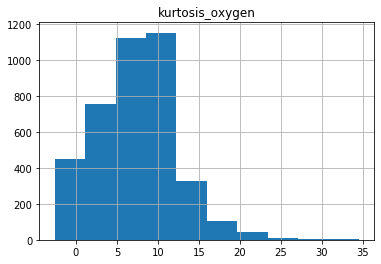

In [146]:
og.hist('kurtosis_oxygen')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000181393F4D30>]],
      dtype=object)

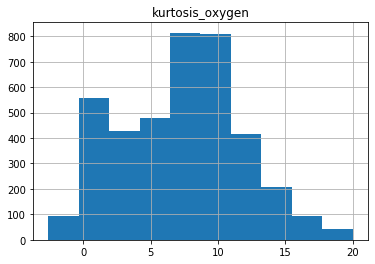

In [147]:
merged_data.hist('kurtosis_oxygen')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000181394790B8>]],
      dtype=object)

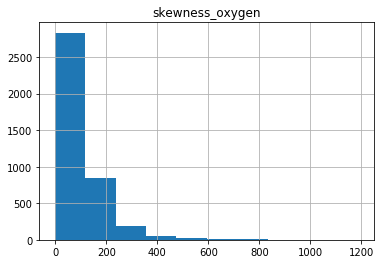

In [148]:
og.hist('skewness_oxygen')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018139505588>]],
      dtype=object)

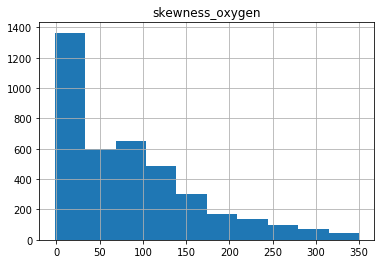

In [149]:
merged_data.hist('skewness_oxygen')

Pri porovnani pairplotov mozeme vidiet mierne zmeny. Pri niektorych datach sa zvacsilo rozpatie hodnot (napr. kurtosis glucose a skewness glucose).

In [ ]:
sns.pairplot(og, hue="class")

C:\Users\Lukas\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Lukas\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Lukas\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Lukas\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


In [ ]:
sns.pairplot(merged_data, hue="class")

Na vybratych scatterplotoch mozeme vidiet mierne zmeny v rozdeleni dat. Ide hlavne o zmensenie rozpati pri tychto datach.

In [ ]:
sns.scatterplot(x=og['kurtosis_glucose'], y=og['kurtosis_oxygen'], hue=og['class'], alpha=0.5)

In [ ]:
sns.scatterplot(x=merged_data['kurtosis_glucose'], y=merged_data['kurtosis_oxygen'], hue=merged_data['class'], alpha=0.5)

In [ ]:
sns.scatterplot(x=og['mean_glucose'], y=og['mean_oxygen'], hue=og['class'], alpha=0.5)

In [ ]:
sns.scatterplot(x=merged_data['mean_glucose'], y=merged_data['mean_oxygen'], hue=merged_data['class'], alpha=0.5)

In [ ]:
sns.scatterplot(x=og['skewness_glucose'], y=og['skewness_oxygen'], hue=og['class'], alpha=0.5)

In [ ]:
sns.scatterplot(x=merged_data['skewness_glucose'], y=merged_data['skewness_oxygen'], hue=merged_data['class'], alpha=0.5)

In [ ]:
sns.scatterplot(x=og['std_glucose'], y=og['std_oxygen'], hue=og['class'], alpha=0.5)

In [ ]:
sns.scatterplot(x=merged_data['std_glucose'], y=merged_data['std_oxygen'], hue=merged_data['class'], alpha=0.5)

In [ ]:
sns.scatterplot(x=og['kurtosis_oxygen'], y=og['std_oxygen'], hue=og['class'], alpha=0.5)

In [ ]:
sns.scatterplot(x=merged_data['kurtosis_oxygen'], y=merged_data['std_oxygen'], hue=merged_data['class'], alpha=0.5)

Doslo aj ku jemnym zmenam pri korelaciach jednotlivych hodnot. Avsak nejde o nejake drasticke zmeny, vacsinou o zopar stotin alebo tisicin.

In [ ]:
og.corr()

In [ ]:
merged_data.corr()

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(og.corr(), ax=ax, annot=True, fmt=".3f")

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(merged_data.corr(), ax=ax, annot=True, fmt=".3f")